<a href="https://colab.research.google.com/github/AlvinScrp/LLMs-from-scratch-CN/blob/main/finetuning-for-instruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第七章：指令微调

In [11]:
##屏蔽进度条，github中不支持显示，整个notebook都不显示了
import os
# 设置这个环境变量来禁用tqdm进度条
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

import datasets
datasets.disable_progress_bar()

from importlib.metadata import version
import json
import os
import urllib
def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data
# 在网上下载并打开数据库

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))
# print("Example entry data[50]:\n", data[50])
#有时input可能为空
# print("Another example entry data[999]:\n", data[999])

def format_input(entry):
    # 使用数据库的提示词
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # 如果没有输入的格式，将如何处理
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

# model_input = format_input(data[50])
# desired_response = f"\n\n### Response:\n{data[50]['output']}"
# print(model_input + desired_response)

# 自定义训练集、测试集和验证集的大小
train_portion = int(len(data) * 0.85)  # 85% 作为训练集
test_portion = int(len(data) * 0.1)    # 10% 作为测试集
val_portion = len(data) - train_portion - test_portion  # 剩下的 5% 作为验证集

# 划分数据集
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    # 指示数据类的构建
    def __init__(self, data, tokenizer):
        self.data = data
        # 实例化数据
        # 对文本进行预编码
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
    # 链表访问
    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

import tiktoken
# gpt2作为编码模型
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, attention_mask_lst, targets_lst = [], [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        attention_mask = inputs != pad_token_id # Corrected attention mask

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
            attention_mask = attention_mask[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
        attention_mask_lst.append(attention_mask) # Collect attention mask

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    attention_mask_tensor = torch.stack(attention_mask_lst).to(device) # Stack collected attention masks

    return {
        "input_ids": inputs_tensor,
        "labels": targets_tensor,
        "attention_mask": attention_mask_tensor
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

from functools import partial
# 初始化定义
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)
# 初始化训练
train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

# 初始化验证与测试
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)
# print("Train loader:")
# for batch in train_loader:
#     print(f'inputs:{batch["input_ids"]}')
#     print(f'targets:{batch["labels"]}')
#     break

import torch
from torch import nn
from transformers import GPT2Tokenizer, GPT2Model
model_name = "gpt2-medium"
class MyGPT2LMHeadModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.gpt2 = GPT2Model.from_pretrained(model_name)
    config = self.gpt2.config
    self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
    self.lm_head.weight = self.gpt2.wte.weight

  def forward(self,in_idx,attention_mask=None):
    gpt2_out = self.gpt2(in_idx,attention_mask=attention_mask) # Pass attention_mask to GPT2Model
    logits = self.lm_head(gpt2_out.last_hidden_state)
    return logits

def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            # Pass attention_mask to the model
            logits = model(idx_cond)
        logits = logits[:, -1, :]/temperature
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')

        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

import time
from tqdm import tqdm
def train(model, train_loader,val_loader, optimizer,loss_fn, lr_scheduler, device):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        progress_bar = tqdm(train_loader,
                            desc=f"Epoch {epoch+1}/{num_epochs}",
                            bar_format="{desc}: {n_fmt}/{total_fmt} {postfix}")

        total_train_loss = 0  # 初始化总损失
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                in_idx=batch["input_ids"],
                attention_mask=batch["attention_mask"])
            # Need to flatten the logits and labels for CrossEntropyLoss
            loss = loss_fn(outputs.view(-1, outputs.size(-1)), batch["labels"].view(-1))
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
            cost = time.time() - start_time
            progress_bar.set_postfix({"Cost": f"{cost:.2f}s"})

        # 3. 评估循环
        model.eval()
        total_correct = 0
        total_samples = 0
        total_loss = 0  # 初始化总损失

        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                logits = model(
                    in_idx=batch["input_ids"],
                    attention_mask=batch["attention_mask"])
                loss = loss_fn(logits.view(-1, logits.size(-1)), batch["labels"].view(-1))
                total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            # Need to flatten labels for comparison
            total_correct += (predictions.view(-1) == batch["labels"].view(-1)).sum().item()
            total_samples += batch["labels"].numel() # Count all elements in labels

        # 计算平均损失和准确率
        avg_val_loss = total_loss / len(val_loader)
        accuracy = total_correct / total_samples

        avg_train_loss = total_train_loss / len(train_loader)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(accuracy)

        # tqdm.write 不会破坏进度条的单行显示
        tqdm.write(
            f"Epoch {epoch+1}/{num_epochs}.                | "
            f"TrainLoss={avg_train_loss:.4f} | "
            f"ValLoss={avg_val_loss:.4f} | "
            f"Acc={accuracy:.4f}")

    return history

from torch.optim import AdamW
from transformers import get_scheduler
import torch
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 初始化模型、优化器、损失函数
model = MyGPT2LMHeadModel()
model.to(device)

#测试generate
input_text = format_input(val_data[0])
print("Input text:\n",input_text)
print('*'*20)
myTokenizer = GPT2Tokenizer.from_pretrained(model_name)
token_ids = generate(
    model=model,
    idx= myTokenizer.encode(input_text, return_tensors='pt').to(device),
    max_new_tokens=100,
    context_size=128,
    top_k=50,
    temperature=0.9,
    eos_id=50256
)

print("Output text:\n", myTokenizer.decode(token_ids[0], skip_special_tokens=True))



# --- 支持：冻结 GPT2 模型的参数，或者只训练某几层 ---
# for param in model.gpt2.parameters():
#     param.requires_grad = False
# ------------------------------------

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 20
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# 2. 训练循环
history = train(
    model = model,
    train_loader=train_loader ,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    lr_scheduler=lr_scheduler,
    device=device
)

Number of entries: 1100
Example entry data[50]:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}
Another example entry data[999]:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'
Training set length: 935
Validation set length: 55
Test set length: 110
[50256]
Device: cuda
Input text:
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
********************
Output text:
 Below is an instruction that describes a task. Write a respon

Epoch 1/20: 116/116 , Cost=64.00s


Epoch 1/20.                | TrainLoss=0.8931 | ValLoss=0.6795 | Acc=0.7085


Epoch 2/20: 116/116 , Cost=62.88s


Epoch 2/20.                | TrainLoss=0.5042 | ValLoss=0.6224 | Acc=0.7225


Epoch 3/20: 116/116 , Cost=62.60s


Epoch 3/20.                | TrainLoss=0.3461 | ValLoss=0.6498 | Acc=0.7238


Epoch 4/20: 116/116 , Cost=63.18s


Epoch 4/20.                | TrainLoss=0.2625 | ValLoss=0.6682 | Acc=0.7241


Epoch 5/20: 116/116 , Cost=62.67s


Epoch 5/20.                | TrainLoss=0.2210 | ValLoss=0.6978 | Acc=0.7249


Epoch 6/20: 116/116 , Cost=62.83s


Epoch 6/20.                | TrainLoss=0.1910 | ValLoss=0.7251 | Acc=0.7257


Epoch 7/20: 116/116 , Cost=62.69s


Epoch 7/20.                | TrainLoss=0.1757 | ValLoss=0.7305 | Acc=0.7227


Epoch 8/20: 116/116 , Cost=62.77s


Epoch 8/20.                | TrainLoss=0.1633 | ValLoss=0.7317 | Acc=0.7268


Epoch 9/20: 116/116 , Cost=62.94s


Epoch 9/20.                | TrainLoss=0.1584 | ValLoss=0.7365 | Acc=0.7254


Epoch 10/20: 116/116 , Cost=62.86s


Epoch 10/20.                | TrainLoss=0.1518 | ValLoss=0.7979 | Acc=0.7265


Epoch 11/20: 116/116 , Cost=62.72s


Epoch 11/20.                | TrainLoss=0.1472 | ValLoss=0.7920 | Acc=0.7284


Epoch 12/20: 116/116 , Cost=62.71s


Epoch 12/20.                | TrainLoss=0.1441 | ValLoss=0.7972 | Acc=0.7270


Epoch 13/20: 116/116 , Cost=63.10s


Epoch 13/20.                | TrainLoss=0.1420 | ValLoss=0.8062 | Acc=0.7270


Epoch 14/20: 116/116 , Cost=62.66s


Epoch 14/20.                | TrainLoss=0.1393 | ValLoss=0.8213 | Acc=0.7273


Epoch 15/20: 116/116 , Cost=62.87s


Epoch 15/20.                | TrainLoss=0.1372 | ValLoss=0.8311 | Acc=0.7284


Epoch 16/20: 116/116 , Cost=62.58s


Epoch 16/20.                | TrainLoss=0.1349 | ValLoss=0.8440 | Acc=0.7273


Epoch 17/20: 116/116 , Cost=62.15s


Epoch 17/20.                | TrainLoss=0.1327 | ValLoss=0.8542 | Acc=0.7284


Epoch 18/20: 116/116 , Cost=62.82s


Epoch 18/20.                | TrainLoss=0.1307 | ValLoss=0.8633 | Acc=0.7278


Epoch 19/20: 116/116 , Cost=62.77s


Epoch 19/20.                | TrainLoss=0.1283 | ValLoss=0.8785 | Acc=0.7284


Epoch 20/20: 116/116 , Cost=62.89s


Epoch 20/20.                | TrainLoss=0.1256 | ValLoss=0.8889 | Acc=0.7286


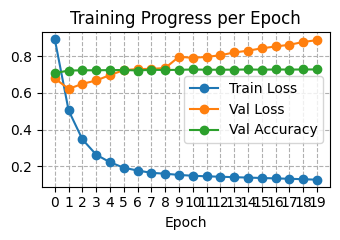

In [12]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(len(history["train_loss"]))  # [0, 1, 2, ...]

plt.figure(figsize=(3.5, 2.5))

# 三条曲线
plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o", color="tab:blue")
plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o", color="tab:orange")
plt.plot(epochs, history["val_acc"], label="Val Accuracy", marker="o", color="tab:green")

# 图表美化
plt.title("Training Progress per Epoch")
plt.xlabel("Epoch")
plt.xticks(epochs)  # x 轴从 0 开始为整数
plt.grid(True, linestyle="--", alpha=1)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
#测试generate
# input_text = format_input(val_data[0])
# print("Input text:\n",input_text)
# print('*'*20)
# myTokenizer = GPT2Tokenizer.from_pretrained(model_name)
# token_ids = generate(
#     model=model,
#     idx= myTokenizer.encode(input_text, return_tensors='pt').to(device),
#     max_new_tokens=100,
#     context_size=128,
#     top_k=50,
#     temperature=0.9
# )

# print("Output text:\n", myTokenizer.decode(token_ids[0], skip_special_tokens=True))

myTokenizer = GPT2Tokenizer.from_pretrained(model_name)
for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx= myTokenizer.encode(input_text, return_tensors='pt').to(device),
        max_new_tokens=256,
        context_size=128,
        top_k=50,
        temperature=0.9,
        eos_id=50256
    )
    generated_text = myTokenizer.decode(token_ids[0], skip_special_tokens=True)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")




Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of storm that develops quickly and is accompanied by frequent occurrence of precipitation.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

